<a href="https://colab.research.google.com/github/rahulkp03/Deep-Learning-Projects/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer-Learning 






In [1]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
num_classes = 100
nb_epochs = 10

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)

169001437/169001437 [==============================] - 6s 0us/step


In [4]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_9 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, None, None, None)  0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [6]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

t=time.time()
historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=15,
                                  validation_data=(x_test, y_test))
print('Training time: %s' % (t - time.time()))

<ipython-input-7-3bdd975ef4c5>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historytemp = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/15
781/781 [==============================] - 519s 636ms/step - loss: 2.0128 - accuracy: 0.4819 - val_loss: 1.0055 - val_accuracy: 0.7068
Epoch 2/15
781/781 [==============================] - 495s 634ms/step - loss: 1.1659 - accuracy: 0.6654 - val_loss: 0.8369 - val_accuracy: 0.7503
Epoch 3/15
781/781 [==============================] - 495s 633ms/step - loss: 0.9812 - accuracy: 0.7119 - val_loss: 0.7756 - val_accuracy: 0.7687
Epoch 4/15
781/781 [==============================] - 487s 624ms/step - loss: 0.8713 - accuracy: 0.7398 - val_loss: 0.7348 - val_accuracy: 0.7830
Epoch 5/15
781/781 [==============================] - 494s 633ms/step - loss: 0.7982 - accuracy: 0.7587 - val_loss: 0.7347 - val_accuracy: 0.7781
Epoch 6/15
781/781 [==============================] - 495s 633ms/step - loss: 0.7398 - accuracy: 0.7762 - val_loss: 0.7262 - val_accuracy: 0.7828
Epoch 7/15
781/781 [==============================] - 494s 633ms/step - loss: 0.6879 - accuracy: 0.7893 - val_loss: 0.7219 -

In [ ]:
#model.save_weights("cifar100.h5")

# model

In [ ]:
model.load_weights("cifar100.h5")

In [8]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 35s 110ms/step - loss: 0.7384 - accuracy: 0.8003


[0.7383863925933838, 0.8003000020980835]

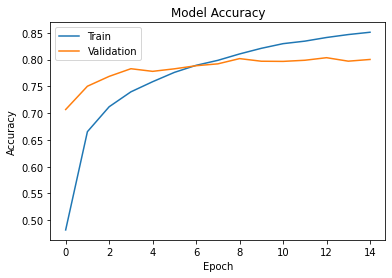

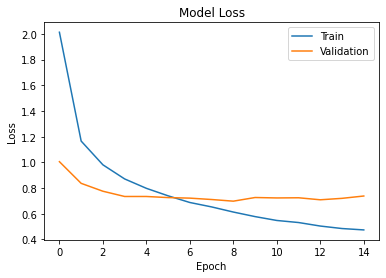

In [9]:
plt.plot(historytemp.history['accuracy'])
plt.plot(historytemp.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(historytemp.history['loss'])
plt.plot(historytemp.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()